In [ ]:
#imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from tqdm import tqdm_notebook as tqdm

In [ ]:
#Data preprocessing

file_name = "inst3d1.csv"
df = pd.read_csv(file_name)

products_df, layers_df, pallets_df, trucks_df  = pd.DataFrame(columns=["products"]), pd.DataFrame(columns=["layers"]), pd.DataFrame(columns=["pallets"]), pd.DataFrame(columns=["trucks"])

column_name = ""
for df_column_name, item in df.items():
  column_name = df_column_name

flag = "products"
for index, row in df.iterrows():
  item = row[column_name]
  if "layers" in item:
    flag = "layers"
  elif "pallets" in item:
    flag = "pallets"
  elif "trucks" in item:
    flag = "trucks"
  
  if "layers" in item or "pallets" in item or "trucks" in item:
    continue
  if flag == "layers":
    layers_df.loc[index] = [item] 
  elif flag == "pallets":
    pallets_df.loc[index] = [item] 
  elif flag == "trucks":
    trucks_df.loc[index] = [item] 
  else:
    products_df.loc[index] = [item]

print(products_df) 
print(layers_df)
print(pallets_df)
print(trucks_df)

                                              products
0       1 0 52 186.00 254.00 171.00 4.63 1 1 1 1 0 0 1
1       2 1 78 186.00 254.00 171.00 4.63 1 1 1 1 0 0 2
2       3 2 78 186.00 254.00 171.00 4.63 1 1 1 1 0 0 3
3       4 0 26 179.00 238.00 185.00 5.08 1 1 1 1 0 0 4
4       5 1 78 179.00 238.00 185.00 5.08 1 1 1 1 0 0 5
..                                                 ...
181  182 1 200 151.00 197.00 270.00 4.56 1 1 1 1 0 ...
182  183 2 120 151.00 197.00 270.00 4.56 1 1 1 1 0 ...
183  184 0 80 151.00 197.00 270.00 4.56 1 1 1 1 0 0...
184  185 1 80 151.00 197.00 270.00 4.56 1 1 1 1 0 0...
185  186 2 240 151.00 197.00 270.00 4.56 1 1 1 1 0 ...

[186 rows x 1 columns]
                                       layers
187    1 997.00 1270.00 171.40 120.30 0 26 8 
188    2 997.00 1270.00 171.40 120.30 0 26 8 
189    3 997.00 1270.00 171.40 120.30 0 26 8 
190    4 955.50 1190.50 184.90 132.08 0 26 7 
191    5 955.50 1190.50 184.90 132.08 0 26 7 
..                                      

In [ ]:
#extracting the number of products
df = pd.read_csv(file_name, header=None)
product_number = int(df.values[0][0].split(' ')[1])

In [ ]:
#Finding the indecis of the product features (width, length, height)

np.array(products_df.values[0][0].split(' ')[3 : 6]).astype(np.float)

array([186., 254., 171.])

In [ ]:
#extracting product features
product_features = np.zeros((product_number, 3))
for i in range(product_number):
  product_features[i] = np.array(products_df.values[i][0].
                              split(' ')[3 : 6]).astype(np.float)
total_products_volume = np.sum(np.product(product_features, axis=1))
print('total volume of product# (m3): ', total_products_volume/10e9)  

#unit casting (mm -> cm) to reduce the memory consumption
#procuct features (consider ceil of dimensions)
product_features_cm = np.ceil(product_features/10).astype(np.int32)

total volume of product# (m3):  0.1507635555


In [ ]:
#extracting truck features
truck_w, truck_l, truck_h = np.array(
    trucks_df.values[0][0].split(' ')[1:4]).astype(np.float)

print('the volume of truck is (m3): ', truck_w*truck_l*truck_h/10e9)

#unit casting (mm -> cm)
#truck's features (consider floor of dimensions by make them int)
truck_l_cm = int(truck_l/10)
truck_h_cm = int(truck_h/10)
truck_w_cm = int(truck_w/10)

the volume of truck is (m3):  10.3280718985


In [ ]:
#extracting pallet features
pal_w, pal_l, pal_h = np.array(
    pallets_df.values[0][0].split(' ')[1:4]).astype(np.float)

print('the volume of pallet is (m3): ', pal_w*pal_l*(truck_h - pal_h)/10e9)

#unit casting (mm -> cm)
#pallet's features (consider floor of dimensions by make them int) 
#this part is already uselees, may be would useful for future works
pal_l_cm = int(pal_l/10)
pal_h_cm = int(pal_h/10)
pal_w_cm = int(pal_w/10)

the volume of pallet is (m3):  0.3033096296


In [ ]:
# function4: fixing a product to the most back-left-bottom point
def fix_product_place(truck_grid, particle, i, z, xi, yi):
  sign = 1
  if i % 2 == 0:
    sign = -1

  z1 = z
  z2 = z1 + product_features_cm[i,2]

  y1 = yi
  y2 = y1 + product_features_cm[i,0]

  # for back
  x = xi
  xi_new  = truck_l_cm - product_features_cm[i,1] - 1
  while True:
    area = truck_grid[y1:y2 , x , z1:z2]
    if np.sum(area.reshape(-1)) == 0 and x > 0:
      x -= 1
    else:
      xi_new = x + 1
      break


  # for left
  x1 = xi_new
  x2 = xi_new + product_features_cm[i, 1]
  y = yi
  while True:
    area = truck_grid[y , x1:x2 , z1:z2]
    if np.sum(area.reshape(-1)) == 0 and y > 0 and y + product_features_cm[i, 0] < truck_w_cm-1:
      y -= 1 * sign
    else:
      yi_new = y + sign
      break


  x1 = xi_new
  x2 = xi_new + product_features_cm[i,1]

  y1 = yi_new
  y2 = y1 + product_features_cm[i,0]

  #moving from bottom upward
  zi_new = truck_h_cm - product_features_cm[i,2] - 1
  for z in range(truck_h_cm - product_features_cm[i,2]):
      area = truck_grid[y1:y2 , x1:x2 , z]
      if np.sum(area.reshape(-1)) == 0:
        zi_new = z
        break

  z1 = zi_new
  z2 = z1 + product_features_cm[i, 2]

  #update the truck's grid
  truck_grid[y1:y2 , x1:x2 , z1:z2] = True

  return xi_new , yi_new , truck_grid , zi_new


#function3: checking if xi, yi is feasible for ith product according to items js<i
def is_feasible(xi, yi, particle, i, truck_grid):
  #checking the feasibilty of width and lenght of items
  if (xi + product_features_cm[i, 1] > truck_l_cm
      ) or (yi + product_features_cm[i, 0] > truck_w_cm):
    return False , -1 , -1 , truck_grid , -1

  #checking the feasibilty of height items (should be lower than height of truck)

  x1 = xi
  x2 = x1 + product_features_cm[i,1]
  y1 = yi
  y2 = y1 + product_features_cm[i,0]
  
  can_place = False #if a product can be lacated in a specific point (height)?
  xi_new = 0
  yi_new = 0
  zi_new = 0

  for z in range(truck_h_cm - product_features_cm[i,2]):
    area = truck_grid[y1:y2 , x1:x2 , z]
    if np.sum(area.reshape(-1)) == 0:
      xi_new , yi_new , truck_grid , zi_new = fix_product_place(truck_grid , particle , i , z , xi , yi)
      can_place = True
      break




  return can_place , xi_new , yi_new , truck_grid , zi_new

#function2: extranting the index of product
def get_index_of_product(order, particle):
  i = np.where(particle[list(range(0, particle_dim, 3))] == order)[0][0]
  return i

#function1: generating a feasible solution to initialize the model
def get_random_feasible_solution(particle_dim):
  # a 3D grid for handling product placement
  truck_grid = np.zeros((truck_w_cm,truck_l_cm,truck_h_cm), np.bool)

  particle = np.zeros((particle_dim) , dtype = np.int32)
  product_sequence = np.arange(product_number, dtype=np.int32)
  np.random.shuffle(product_sequence) #to have different solutions
  for i in range(product_number):
    particle[3*i] = product_sequence[i]


  for order in range(product_number):
    i = get_index_of_product(order , particle)
    while True:
      xi = int(np.random.rand() * (truck_w_cm - product_features_cm[i , 0]))
      # yi = int(np.random.rand() * (truck_l_cm - product_features_cm[i , 1]))

      # y => 0 => width

      # r1 = np.abs(np.random.randn())
      # if r1 > 0.9: r1=0.9
      # xi = int(r1 * (truck_w_cm - product_features_cm[i , 0]))

      r2 = np.abs(np.random.randn())
      if r2 > 0.9: r2=0.9
      yi = int(r2 * (truck_l_cm - product_features_cm[i , 1]))//2

      fis , xi_new , yi_new ,truck_grid , _ = is_feasible(xi, yi, particle, i , truck_grid)
      if fis:
        particle[3*i+1] = xi_new
        particle[3*i+2] = yi_new
        break
  return particle

In [ ]:
#hyperparametrs and coefficients initializing
max_iter = 301 #GA iteration
particle_number = 50 #the number of chromosome (individuals/particles) that we think is appropriate
particle_dim = 3 * product_number #we have 3-tuple representation
w = 0.05 # inertia value
c1 = 0.1 #the importance of personal best
c2 = 0.2 #the importance of global best
penalty = 100 * product_number  #more products needs to get more penilized
cross_over_margin = product_number//10 #margin for cross over operation
X = np.zeros((particle_number, particle_dim) , dtype=np.int32) #particles (individuals) 

#generating initial solutions
for i in tqdm(range(particle_number)):
  X[i] = get_random_feasible_solution(particle_dim) 

# define velocity of  particles for PSO
V = np.random.randn(particle_number , particle_dim) # random number from normal distribution
V[: , np.arange(0,particle_dim , 3)] = 0

# personal bests for PSO
P = X.copy()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  del sys.path[0]


In [ ]:
#show a sample of the solutions' representation
print('this representation means the order of entering the first product \
is ' + str(X[0][0]) + ' and the second one is ' + str(X[0][3]) + ' and so on ...')
print('-------------------------------')
print('x_1 =', str(X[0][2]) , 'y_1 =', str(X[0][1]), 'and', 'x_2 =', str(X[0][5]) , 'y_2 =', str(X[0][4]))
print('-------------------------------')
print(X[0])

this representation means the order of entering the first product is 55 and the second one is 58 and so on ...
-------------------------------
x_1 = 227 y_1 = 115 and x_2 = 142 y_2 = 27
-------------------------------
[ 55 115 227  58  27 142  62   1 126 100   1   1  47  52 220  66   1 182
 128  76 231 113 169   1 159  21 218  56  27 124 135   1  -1 125  27 161
  32  27 227  18   1   1 101 137 222  20  21  67 162 107 222  91  57 145
  19   1 221  50   1 162  57  27 220 121 113   1 179 162  94 166  61  25
 104 137  96 175 150 161  42  27 221 122  83 169   0   1 228 112  89 145
  34   1 221 118  51 169  68  53 221  10   1  43  29  53 221  41  53  61
  92 141 223 172 160  39  80  53 221 102 105  97 174 138 141 114  89  37
  45 109 227  38   1 144  73  51  42 123   1  80  26  89 228  28 105   1
  64  93 226  78 113  57 156   1 226 146 173  16 126 113 226  70  21  59
  40   1 222 165  65   1 133  86 222 163 137  57  23   1 221  43  27  91
 167  25 124 129   1 201 134   1 125  87  25 182   5

In [ ]:
#fitness function
def fitness_func(particle):
  # check if any negative number exists after PSO operation
  if np.any(particle[np.arange(0, particle_dim, 3) + 1] < 0) or \
      np.any(particle[np.arange(0, particle_dim, 3) + 2] < 0):
    return penalty
  
  # check if any product break the truck limits after PSO operation
  for i in range(0, particle_dim, 3):
    if particle[i + 1] + product_features_cm[ i // 3 , 0] > truck_w_cm or \
        particle[i + 2] + product_features_cm[ i // 3 , 1] > truck_l_cm:
      return penalty


  truck_grid = np.zeros((truck_w_cm,truck_l_cm,truck_h_cm), np.bool)
  for order in range(product_number):
    i = get_index_of_product(order , particle)
    xi = particle[3*i+1]
    yi = particle[3*i+2]
    fis , xi_new , yi_new ,truck_grid,_ = is_feasible(xi, yi, particle, i , truck_grid)
    if fis == False:
      return penalty
  
  # Here: Particle is a feasible solution
  for fit in range(truck_l_cm-1 , 0 , -1):
    cut = truck_grid[0 : truck_w_cm , fit , 0: truck_h_cm]
    if np.sum(cut.reshape(-1)) > 0:
      break
    
  return fit

In [ ]:
#repair function to fix particles after each cross-over
def repair_crossover(particle):
  orders = particle[list(range(0,particle_dim , 3))]
  isort = np.argsort(orders)
  for i in range(product_number):
    orders[isort[i]] = i

  particle[list(range(0,particle_dim , 3))] = orders
  return particle

In [ ]:
#Cuboid Plotting Function, can be called by 'final_plot(X_best)'
from mpl_toolkits.mplot3d import Axes3D
from mpl_toolkits.mplot3d.art3d import Poly3DCollection
import numpy as np
import matplotlib.pyplot as plt

def cuboid_data2(o, size=(1,1,1)):
    X = [[[0, 1, 0], [0, 0, 0], [1, 0, 0], [1, 1, 0]],
         [[0, 0, 0], [0, 0, 1], [1, 0, 1], [1, 0, 0]],
         [[1, 0, 1], [1, 0, 0], [1, 1, 0], [1, 1, 1]],
         [[0, 0, 1], [0, 0, 0], [0, 1, 0], [0, 1, 1]],
         [[0, 1, 0], [0, 1, 1], [1, 1, 1], [1, 1, 0]],
         [[0, 1, 1], [0, 0, 1], [1, 0, 1], [1, 1, 1]]]
    X = np.array(X).astype(float)
    for i in range(3):
        X[:,:,i] *= size[i]
    X += np.array(o)
    return X

def plotCubeAt2(positions,sizes=None,colors=None, **kwargs):
    if not isinstance(colors,(list,np.ndarray)): colors=["C0"]*len(positions)
    if not isinstance(sizes,(list,np.ndarray)): sizes=[(1,1,1)]*len(positions)
    g = []
    for p,s,c in zip(positions,sizes,colors):
        g.append( cuboid_data2(p, size=s) )
    return Poly3DCollection(np.concatenate(g),  
                            facecolors=np.repeat(colors,6), **kwargs)

def final_plot(particle):
  #particle = X_best.copy()
  ItemPositions = np.zeros((product_number, 3))
  truck_grid = np.zeros((truck_w_cm, truck_l_cm, truck_h_cm), np.bool)
  for order in range(product_number):
      i = get_index_of_product(order , particle)
      xi = particle[3*i+1]
      yi = particle[3*i+2]
      
      fis , xi_new , yi_new ,truck_grid,zi_new = is_feasible(xi, yi, particle, i , truck_grid)
      ItemPositions[i , 0] = xi_new
      ItemPositions[i , 1] = yi_new
      ItemPositions[i , 2] = zi_new

  positions = ItemPositions
  sizes = product_features_cm
  colors = np.repeat(["crimson", "limegreen", "blue", "yellow", "orange", "darkgreen"], 31)

  fig = plt.figure()
  ax = fig.gca(projection='3d')

  pc = plotCubeAt2(positions,sizes,colors=colors, edgecolor="k")
  ax.add_collection3d(pc)    

  ax.set_xlim([0,200])
  ax.set_ylim([0,250])
  ax.set_zlim([0,260])

  plt.show()

#final_plot(X_best.copy())

#PSO-GA main loop
We use Cross-over operation from GA to change the solutions to find a better answer. Also, PSO would help us to enrich our model in finding better purposeful solutions. We completely ignored mutation in this work since it is too random to be effective.

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:18: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


/usr/local/lib/python3.7/dist-packages/numpy/core/fromnumeric.py:3373: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


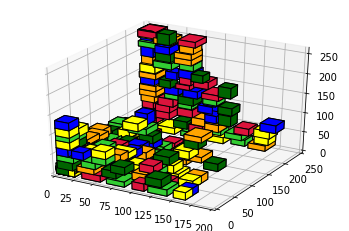

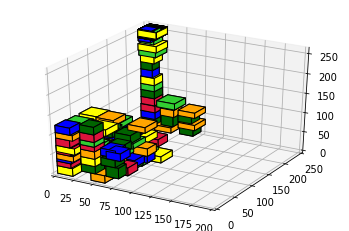

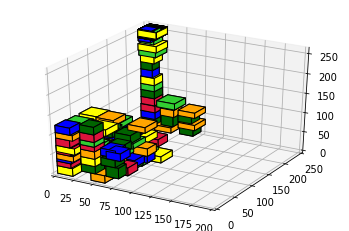

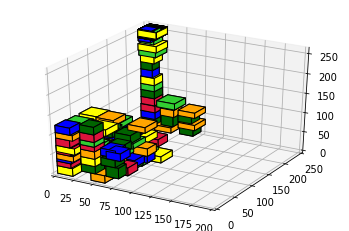

In [14]:
#initializing
fitness_particle = np.zeros(particle_number)
fitness_personal = np.ones(particle_number) * np.infty
X_best = np.zeros_like(X[0])
fitness_best = np.infty

#variables for later plotting 
fitness_best_plot = np.zeros(max_iter)
fitness_mean_plot = np.zeros(max_iter)
fitness_particle_old = np.ones(particle_number) * np.infty

#the number of opportunities that a particle have to improve itself
#otherwise it would be replaced by another random solution
num_pa = 5
X_limit = np.ones(particle_number) * num_pa

#main loop of PSO-GA
for iter in tqdm(range(max_iter)):
  # Compute fitness function for each particle
  for i in range(particle_number):
    fitness_particle[i] = fitness_func(X[i])

  X_limit[fitness_particle >= fitness_particle_old] -= 1
  X_limit[fitness_particle < fitness_particle_old] = num_pa

  for i in range(particle_number):
    if X_limit[i] == 0:
      X[i] = get_random_feasible_solution(particle_dim)
      fitness_particle[i] = fitness_func(X[i])
      X_limit[i] = num_pa
      V[i] = np.random.randn(1 , particle_dim) # random number from normal distribution
      V[i , np.arange(0,particle_dim , 3)] = 0


  fitness_particle_old = fitness_particle

  fitness_mean_plot[iter] = np.mean(fitness_particle[fitness_particle != penalty])

  # sort particles
  isort = np.argsort(fitness_particle)
  X = X[isort]
  P = P[isort]
  V = V[isort]
  fitness_particle = fitness_particle[isort]
  fitness_personal = fitness_personal[isort]

  # Update Personal bests
  P[fitness_particle < fitness_personal ,] = np.array(X[fitness_particle < fitness_personal ,])
  fitness_personal[fitness_particle < fitness_personal] = np.array(fitness_particle[fitness_particle < fitness_personal])

  # Update Global best
  if fitness_particle.min() < fitness_best :
    X_best = X[np.argmin(fitness_particle)]
    fitness_best = fitness_particle.min()

  fitness_best_plot[iter] = fitness_best

  # GA cross-over phase (assume that particles are sorted accoroding to fitness )
  for i in range(0,particle_number, 2):
    par1 = X[i].copy()
    par2 = X[i + 1].copy()
    # use one-point cross over
    p = np.random.randint(low =  cross_over_margin, high = product_number - cross_over_margin) * 3
    X[i + 1 , 0:p] = par1[0 : p]
    X[i , 0:p] = par2[0 : p]

    X[i] = repair_crossover(X[i])
    X[i+1] = repair_crossover(X[i+1])
  
  # PSO operations
  for i in range(particle_number):
    for d in range(product_number):
      V[i, 3 * d + 1] = w * V[i, 3 * d + 1] + c1 * np.random.rand()*(P[i,3 * d + 1] - X[i,3 * d + 1]) + c2 * np.random.rand() * (X_best[3 * d + 1] - X[i,3 * d + 1])
      V[i, 3 * d + 2] = w * V[i, 3 * d + 2] + c1 * np.random.rand()*(P[i,3 * d + 2] - X[i,3 * d + 2]) + c2 * np.random.rand() * (X_best[3 * d + 2] - X[i,3 * d + 2])

  X = X + np.round(V).astype(np.int32)

  if iter % 100 == 0:
    final_plot(X_best)


In [15]:
print('Best fitness:', fitness_best)
print('Mean fitness:', fitness_mean_plot[-1])

Best fitness: 88.0
Mean fitness: 100.22916666666667


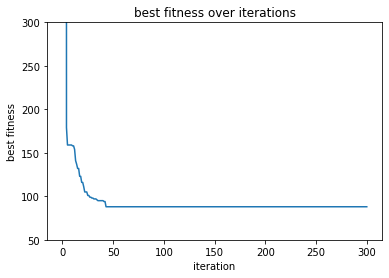

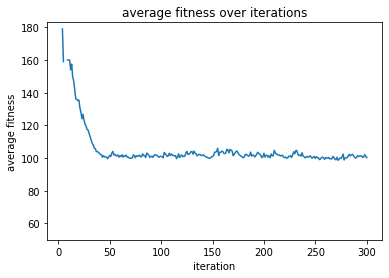

In [23]:
#ploting the fitness
plt.plot(fitness_best_plot)
plt.title('best fitness over iterations')
plt.xlabel('iteration')
plt.ylabel('best fitness')
plt.ylim(50, 300)
plt.show()

plt.plot(fitness_mean_plot)
plt.title('average fitness over iterations')
plt.xlabel('iteration')
plt.ylabel('average fitness')
plt.ylim(50, )
plt.show()